In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [24]:
def create_ocr_model(input_shape=(128, 128, 3)):
    """
    Creates a simple OCR model using CNN.
    
    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
    
    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Assuming 10 classes for demonstration
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model
input_shape = (128, 128, 3)
ocr_model = create_ocr_model(input_shape)
ocr_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
def generate_dummy_data(num_samples=1000, input_shape=(128, 128, 3), num_classes=10):
    """
    Generates dummy data for training the OCR model.
    
    Args:
        num_samples (int): Number of samples to generate.
        input_shape (tuple): Shape of the input image.
        num_classes (int): Number of output classes.
    
    Returns:
        X (numpy.ndarray): Dummy image data.
        y (numpy.ndarray): Dummy labels (one-hot encoded).
    """
    X = np.random.rand(num_samples, *input_shape).astype('float32')
    y = np.random.randint(0, num_classes, size=(num_samples,))
    y = tf.keras.utils.to_categorical(y, num_classes)
    return X, y

# Generate training and validation data
X_train, y_train = generate_dummy_data(num_samples=1000, input_shape=input_shape)
X_val, y_val = generate_dummy_data(num_samples=200, input_shape=input_shape)


In [26]:
# Train the OCR model
history = ocr_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

# Save the model for later use (optional)
ocr_model.save("ocr_model_on_cpu.h5")


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 0.1076 - loss: 4.1782 - val_accuracy: 0.0900 - val_loss: 2.3025
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.0995 - loss: 2.3026 - val_accuracy: 0.0750 - val_loss: 2.3029
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.1304 - loss: 2.3024 - val_accuracy: 0.0750 - val_loss: 2.3033
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.1265 - loss: 2.3003 - val_accuracy: 0.0800 - val_loss: 2.3054
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.1127 - loss: 2.2974 - val_accuracy: 0.0800 - val_loss: 2.3051


In [42]:
import time  # Import time module for measuring processing times

def process_frames_with_ocr(video_path, model, batch_size=1):
    """
    Process video frames using the OCR model on CPU and record processing times.
    
    Args:
        video_path (str): Path to the video file.
        model (tensorflow.keras.Model): OCR model.
        batch_size (int): Number of frames to process at once.
    
    Returns:
        processed_frames (list): List of predictions for each frame.
        processing_times (list): List of time taken to process each batch of frames.
    """
    video_capture = cv2.VideoCapture(video_path)
    processed_frames = []
    processing_times = []
    frame_batch = []

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, (128, 128)) / 255.0
        frame_batch.append(resized_frame)

        if len(frame_batch) == batch_size:
            start_time = time.time()  # Start timer
            batch_array = np.array(frame_batch)
            predictions = model.predict(batch_array, verbose=0)
            end_time = time.time()  # End timer
            
            batch_time = (end_time - start_time) * 1000  # Time in milliseconds
            processing_times.extend([batch_time / batch_size] * batch_size)  # Record time per frame
            
            processed_frames.extend(predictions)
            frame_batch = []

    if frame_batch:
        start_time = time.time()
        batch_array = np.array(frame_batch)
        predictions = model.predict(batch_array, verbose=0)
        end_time = time.time()

        batch_time = (end_time - start_time) * 1000
        processing_times.extend([batch_time / len(frame_batch)] * len(frame_batch))
        processed_frames.extend(predictions)

    video_capture.release()
    return processed_frames, processing_times


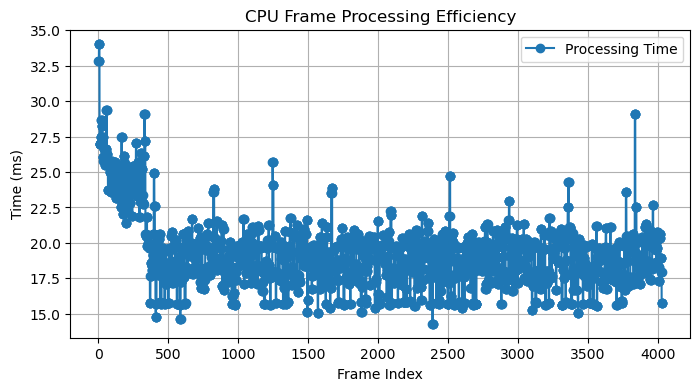

In [44]:
# Process the video and record frame processing times
video_file = "Downloads\\WhatsApp Video 2024-11-20 at 22.19.35_e2af8e97.mp4"
processed_frames, processing_times = process_frames_with_ocr(video_file, ocr_model, batch_size=4)

# Generate frame indices
frame_indices = list(range(len(processed_frames)))

# Visualize processing efficiency
visualize_processing_efficiency(processing_times, frame_indices)


In [40]:
def visualize_processing_efficiency(cpu_times, frame_counts, title="CPU Frame Processing Efficiency"):
    """
    Visualizes CPU processing efficiency for video frames.
    
    Args:
        cpu_times (list): Time taken for each frame.
        frame_counts (list): Frame indices.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(frame_counts, cpu_times, marker='o', label="Processing Time")
    plt.xlabel("Frame Index")
    plt.ylabel("Time (ms)")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


In [46]:
def measure_processing_times(video_path, model, batch_size=1, device="CPU"):
    """
    Measure processing times for CPU or GPU while processing video frames with OCR.
    
    Args:
        video_path (str): Path to the video file.
        model (tensorflow.keras.Model): OCR model.
        batch_size (int): Number of frames to process at once.
        device (str): "CPU" or "GPU" to specify processing hardware.
    
    Returns:
        processing_times (list): List of time taken to process each batch of frames.
    """
    import time
    from tensorflow.python.framework import config

    # Set processing device
    if device == "CPU":
        tf.config.set_visible_devices([], 'GPU')  # Disable GPU
    elif device == "GPU":
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)

    video_capture = cv2.VideoCapture(video_path)
    processing_times = []
    frame_batch = []

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, (128, 128)) / 255.0
        frame_batch.append(resized_frame)

        if len(frame_batch) == batch_size:
            start_time = time.time()
            batch_array = np.array(frame_batch)
            model.predict(batch_array, verbose=0)  # Perform inference
            end_time = time.time()
            
            batch_time = (end_time - start_time) * 1000  # Convert to milliseconds
            processing_times.extend([batch_time / batch_size] * batch_size)  # Record time per frame
            
            frame_batch = []

    if frame_batch:
        start_time = time.time()
        batch_array = np.array(frame_batch)
        model.predict(batch_array, verbose=0)
        end_time = time.time()

        batch_time = (end_time - start_time) * 1000
        processing_times.extend([batch_time / len(frame_batch)] * len(frame_batch))

    video_capture.release()
    return processing_times


In [48]:
# Measure CPU processing times
cpu_times = measure_processing_times(video_file, ocr_model, batch_size=4, device="CPU")

# Measure GPU processing times
gpu_times = measure_processing_times(video_file, ocr_model, batch_size=4, device="GPU")

# Generate frame indices
frame_indices = list(range(len(cpu_times)))  # Assuming frame counts are identical


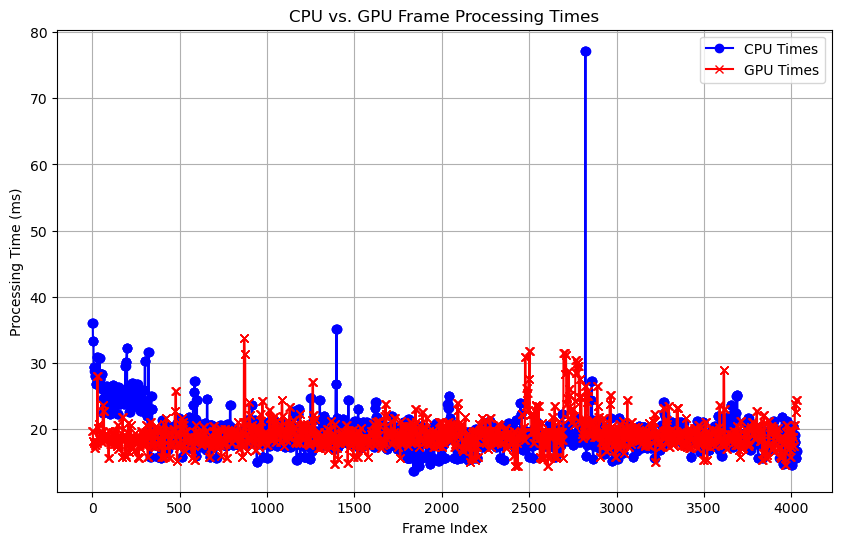

In [49]:
import matplotlib.pyplot as plt

def compare_cpu_gpu(cpu_times, gpu_times, frame_indices):
    """
    Visualize the performance of CPU vs. GPU for frame processing.

    Args:
        cpu_times (list): Processing times for CPU.
        gpu_times (list): Processing times for GPU.
        frame_indices (list): Indices of frames.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(frame_indices, cpu_times, label="CPU Times", color="blue", marker="o")
    plt.plot(frame_indices, gpu_times, label="GPU Times", color="red", marker="x")
    plt.xlabel("Frame Index")
    plt.ylabel("Processing Time (ms)")
    plt.title("CPU vs. GPU Frame Processing Times")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize CPU vs GPU processing times
compare_cpu_gpu(cpu_times, gpu_times, frame_indices)
